# Data Exploration, Processing, and Model Fitting, Evaluation Notebook

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.sparse import hstack
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression

from tqdm import tqdm

plt.rcParams['figure.figsize'] = (15, 6)  # Width, Height in inches

pd.set_option("display.max_columns", 50)

# Data Processing

In [3]:
df = pd.read_csv("project_data.csv")

# fixing dates
df["date"] = pd.to_datetime(df["date"])

df

/var/folders/n5/2fld4dp113dfbc1h0f87y9_r0000gn/T/ipykernel_78838/29106677.py:1: DtypeWarning: Columns (6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("project_data.csv")


,player_id,name,position,points_won,start_rank,end_rank,tournament_id,R1,R2,R3,R4,R5,total,week,year,date,event,field_rating,tour_id,tour_name,tour_code,is_eligible
0,449.0,Mark McNulty,1,10.0,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,5,1986,1986-02-02,Wild Coast Class,0.0,2,Sunshine Tour,Afr,True
1,440.0,David Frost,2,6.0,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,5,1986,1986-02-02,Wild Coast Class,0.0,2,Sunshine Tour,Afr,True
2,446.0,Tony Johnstone,3,4.0,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,5,1986,1986-02-02,Wild Coast Class,0.0,2,Sunshine Tour,Afr,True
3,95.0,Rick Hartmann,T4,4.0,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,5,1986,1986-02-02,Wild Coast Class,0.0,2,Sunshine Tour,Afr,True
4,265.0,David Feherty,T4,4.0,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,5,1986,1986-02-02,Wild Coast Class,0.0,2,Sunshine Tour,Afr,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140530,19455.0,Guillermo Mito Pereira,T47,NaN,NaN,NaN,36_liv,73.0,71.0,71.0,NaN,NaN,215.0,37,2024,2024-09-15,Chicago_liv,NaN,41,Liv Golf,liv,False
1140531,12337.0,Jason Kokrak,51,NaN,NaN,NaN,36_liv,73.0,73.0,70.0,NaN,NaN,216.0,37,2024,2024-09-15,Chicago_liv,NaN,41,Liv Golf,liv,False
1140532,15856.0,Cameron Smith,52,NaN,NaN,NaN,36_liv,73.0,73.0,74.0,NaN,NaN,220.0,37,2024,2024-09-15,Chicago_liv,NaN,41,Liv Golf,liv,False
1140533,14706.0,Hudson Swafford,53,NaN,NaN,NaN,36_liv,78.0,78.0,67.0,NaN,NaN,223.0,37,2024,2024-09-15,Chicago_liv,NaN,41,Liv Golf,liv,False


In [4]:
# Melt the dataframe
df_melted = pd.melt(
    df,
    id_vars=['player_id', 'name', 'position', 'points_won', 'start_rank', 'end_rank',
       'tournament_id', 'total', 'week', 'year',
       'date', 'event', 'field_rating', 'tour_id', 'tour_name', 'tour_code',
       'is_eligible'],  # Columns to keep
    value_vars=['R1', 'R2', 'R3', 'R4', 'R5'],  # Columns to unpivot
    var_name='Round',  # Name for the new 'Round' column
    value_name='Score'  # Name for the new 'Score' column
)

df_melted['Score'] = df_melted['Score'].replace("-", np.nan)
df_melted = df_melted.dropna(subset="Score")
df_melted["Score"] = df_melted["Score"].astype(float).astype(int)
df_melted = df_melted[df_melted["Score"] > 55]
df_melted = df_melted[df_melted["Score"] < 100]

df_melted["Round"] = df_melted['Round'].replace("R1", 1).replace("R2", 2).replace("R3", 3).replace("R4", 4).replace("R5", 5)

tournaments = df_melted["tournament_id"].unique()

tourney_d = {}
for i in range(len(tournaments)):
    tourney_d[tournaments[i]] = i

df_melted["tourney_id"] = df_melted["tournament_id"].map(tourney_d)

# Get all unique pairs from 'tournament_id' and 'Round'
unique_pairs = df_melted[['tourney_id', 'Round']].drop_duplicates()

# Convert to a list of tuples if needed
unique_pairs_list = list(unique_pairs.itertuples(index=False, name=None))

tourney_rounds_d = {}
for i in range(len(unique_pairs_list)):
    tourney_rounds_d[unique_pairs_list[i]] = i

df_melted['tournament_round'] = list(zip(df_melted['tourney_id'], df_melted['Round']))
df_melted["tournament_round"] = df_melted["tournament_round"].map(tourney_rounds_d)

df_melted["player_id"] = df_melted["player_id"].astype(int)

tournament_round_scores = dict(df_melted.groupby("tournament_round")["Score"].mean())
df_melted["round_scoring_average"] = df_melted["tournament_round"].map(tournament_round_scores)
df_melted["raw_strokes_gained"] = df_melted["round_scoring_average"] - df_melted["Score"]

df_melted = df_melted[~((df_melted["raw_strokes_gained"] >= 10)&((df_melted["position"] == "WD")|(df_melted["position"] == "MC")))]

tournament_round_scores = dict(df_melted.groupby("tournament_round")["Score"].mean())
df_melted["round_scoring_average"] = df_melted["tournament_round"].map(tournament_round_scores)
df_melted["raw_strokes_gained"] = df_melted["round_scoring_average"] - df_melted["Score"]

bad_events = df_melted[df_melted["round_scoring_average"] < 65].tournament_id.unique()
df_melted = df_melted[~df_melted["tournament_id"].isin(bad_events)]

# some random outlier eventd
df_melted = df_melted[df_melted["event"] != "Master of the Monster"]

years = df_melted["year"].unique()

year_bucket_dict = {}

if len(years) % 2 == 1:
    for i in range(0, 3):
        year_bucket_dict[years[i]] = 0
    for i in range(3, len(years)):
        year_bucket_dict[years[i]] = (i-1) // 2
else:
    for i in range(len(years)):
        year_bucket_dict[years[i]] = i // 2
    
df_melted["regression_bucket"] = df_melted["year"].map(year_bucket_dict)
df_melted

,player_id,name,position,points_won,start_rank,end_rank,tournament_id,total,week,year,date,event,field_rating,tour_id,tour_name,tour_code,is_eligible,Round,Score,tourney_id,tournament_round,round_scoring_average,raw_strokes_gained,regression_bucket
410520,9365,James Heath,1,12.00,406.0,259.0,3599,261,34,2006,2006-08-27,ECCO Tour Championship,2.0,10,Challenge Tour,Cha,True,1,65,0,0,69.774194,4.774194,0
410521,6513,Thomas Norret,2,7.20,1269.0,624.0,3599,264,34,2006,2006-08-27,ECCO Tour Championship,2.0,10,Challenge Tour,Cha,True,1,69,0,0,69.774194,0.774194,0
410522,8135,Felipe Aguilar,T3,4.20,540.0,439.0,3599,265,34,2006,2006-08-27,ECCO Tour Championship,2.0,10,Challenge Tour,Cha,True,1,65,0,0,69.774194,4.774194,0
410523,9199,Roope Kakko,T3,4.20,774.0,627.0,3599,265,34,2006,2006-08-27,ECCO Tour Championship,2.0,10,Challenge Tour,Cha,True,1,66,0,0,69.774194,3.774194,0
410524,6166,Birgir Hafthorsson,T5,2.64,962.0,742.0,3599,266,34,2006,2006-08-27,ECCO Tour Championship,2.0,10,Challenge Tour,Cha,True,1,66,0,0,69.774194,3.774194,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5106807,10180,Michael Putnam,T68,0.00,356.0,363.0,4722,349,3,2011,2011-01-23,Bob Hope Classic,163.0,23,PGA Tour,PGAT,True,5,72,943,20553,69.410959,-2.589041,2
5106808,14013,Cameron Tringale,T68,0.00,529.0,532.0,4722,349,3,2011,2011-01-23,Bob Hope Classic,163.0,23,PGA Tour,PGAT,True,5,74,943,20553,69.410959,-4.589041,2
5106809,3682,Scott McCarron,71,0.00,366.0,371.0,4722,350,3,2011,2011-01-23,Bob Hope Classic,163.0,23,PGA Tour,PGAT,True,5,78,943,20553,69.410959,-8.589041,2
5106810,6300,John Rollins,T72,0.00,173.0,178.0,4722,351,3,2011,2011-01-23,Bob Hope Classic,163.0,23,PGA Tour,PGAT,True,5,75,943,20553,69.410959,-5.589041,2


In [5]:
dfs = [group for _, group in df_melted.groupby("regression_bucket")]

for i in tqdm(range(len(dfs))):
    # Initialize OneHotEncoder with sparse=True
    player_encoder = OneHotEncoder(sparse=True, dtype='float32')
    event_encoder = OneHotEncoder(sparse=True, dtype='float32')

    # Encode 'player' and 'event_round' columns
    player_dummies = player_encoder.fit_transform(dfs[i][['player_id']])
    event_dummies = event_encoder.fit_transform(dfs[i][['tournament_round']])

    # Combine the sparse matrices
    X_sparse = hstack([player_dummies, event_dummies], format='csr')

    y = dfs[i]["raw_strokes_gained"].values

    # Fit a regression using scikit-learn
    model = LinearRegression(fit_intercept=False)
    model.fit(X_sparse, y)

    players = player_encoder.categories_[0]

    player_rating_dict = dict(zip(players, model.coef_[:len(players)]))

    dfs[i]["estimated_player_rating"] = dfs[i]["player_id"].map(player_rating_dict)

    rounds = event_encoder.categories_[0]

    round_rating_dict = dict(zip(rounds, model.coef_[len(players):]))

    dfs[i]["estimated_round_rating"] = dfs[i]["tournament_round"].map(round_rating_dict)

    pga_tour_benchmark = dfs[i][dfs[i]["tour_code"] == "PGAT"]["estimated_round_rating"].mean()

    dfs[i]["estimated_round_rating"] = dfs[i]["estimated_round_rating"] - pga_tour_benchmark

    dfs[i]["adjusted_strokes_gained"] = dfs[i]["raw_strokes_gained"] - dfs[i]["estimated_round_rating"]

df1 = pd.concat(dfs)
df1

100%|██████████| 9/9 [00:06<00:00,  1.42it/s]


,player_id,name,position,points_won,start_rank,end_rank,tournament_id,total,week,year,date,event,field_rating,tour_id,tour_name,tour_code,is_eligible,Round,Score,tourney_id,tournament_round,round_scoring_average,raw_strokes_gained,regression_bucket,estimated_player_rating,estimated_round_rating,adjusted_strokes_gained
410520,9365,James Heath,1,12.00000,406.0,259.0,3599,261,34,2006,2006-08-27,ECCO Tour Championship,2.00000,10,Challenge Tour,Cha,True,1,65,0,0,69.774194,4.774194,0,1.447872,3.118544,1.655650
410521,6513,Thomas Norret,2,7.20000,1269.0,624.0,3599,264,34,2006,2006-08-27,ECCO Tour Championship,2.00000,10,Challenge Tour,Cha,True,1,69,0,0,69.774194,0.774194,0,1.992350,3.118544,-2.344350
410522,8135,Felipe Aguilar,T3,4.20000,540.0,439.0,3599,265,34,2006,2006-08-27,ECCO Tour Championship,2.00000,10,Challenge Tour,Cha,True,1,65,0,0,69.774194,4.774194,0,2.990305,3.118544,1.655650
410523,9199,Roope Kakko,T3,4.20000,774.0,627.0,3599,265,34,2006,2006-08-27,ECCO Tour Championship,2.00000,10,Challenge Tour,Cha,True,1,66,0,0,69.774194,3.774194,0,2.005417,3.118544,0.655650
410524,6166,Birgir Hafthorsson,T5,2.64000,962.0,742.0,3599,266,34,2006,2006-08-27,ECCO Tour Championship,2.00000,10,Challenge Tour,Cha,True,1,66,0,0,69.774194,3.774194,0,1.777964,3.118544,0.655650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4560151,14419,Jiho Yang,T57,0.09921,727.0,730.0,10603,283,40,2024,2024-10-06,ACN Championship Golf Tournament,33.52272,15,Japan Golf Tour,Jpn,True,4,71,5414,20548,68.819672,-2.180328,8,2.982506,1.600478,-3.780805
4560152,19163,Taiko Nishiyama,T57,0.09921,893.0,897.0,10603,283,40,2024,2024-10-06,ACN Championship Golf Tournament,33.52272,15,Japan Golf Tour,Jpn,True,4,76,5414,20548,68.819672,-7.180328,8,3.057283,1.600478,-8.780805
4560153,26547,Kazuma Manabe(Am),T57,0.09921,2677.0,2447.0,10603,283,40,2024,2024-10-06,ACN Championship Golf Tournament,33.52272,15,Japan Golf Tour,Jpn,True,4,74,5414,20548,68.819672,-5.180328,8,2.641006,1.600478,-6.780805
4560154,17829,Shotaro Wada,60,0.08870,2615.0,2436.0,10603,285,40,2024,2024-10-06,ACN Championship Golf Tournament,33.52272,15,Japan Golf Tour,Jpn,True,4,69,5414,20548,68.819672,-0.180328,8,1.469022,1.600478,-1.780805


# Data Exploration

In [6]:
df1

dfs = [group for _, group in df1.groupby("player_id")]

player_id_dict = {}
player_name_dict = {}
for i in range(len(dfs)):
    player_id_dict[dfs[i].player_id.values[0]] = i
    player_name_dict[dfs[i].name.values[0]] = i

dfs[player_name_dict["Scottie Scheffler"]].sort_values(by=["date", "Round"])

,player_id,name,position,points_won,start_rank,end_rank,tournament_id,total,week,year,date,event,field_rating,tour_id,tour_name,tour_code,is_eligible,Round,Score,tourney_id,tournament_round,round_scoring_average,raw_strokes_gained,regression_bucket,estimated_player_rating,estimated_round_rating,adjusted_strokes_gained
639113,18417,Scottie Scheffler,T22,2.37713,NaN,999.0,5516,276,20,2014,2014-05-18,HP Byron Nelson Championship,250.00000,23,PGA Tour,PGAT,True,1,71,1669,1669,71.096154,0.096154,3,3.894659,0.245920,-0.149766
1779648,18417,Scottie Scheffler,T22,2.37713,NaN,999.0,5516,276,20,2014,2014-05-18,HP Byron Nelson Championship,250.00000,23,PGA Tour,PGAT,True,2,68,1669,7119,70.396104,2.396104,3,3.894659,0.242613,2.153491
2920183,18417,Scottie Scheffler,T22,2.37713,NaN,999.0,5516,276,20,2014,2014-05-18,HP Byron Nelson Championship,250.00000,23,PGA Tour,PGAT,True,3,69,1669,12565,69.821429,0.821429,3,3.894659,-0.054670,0.876099
4060718,18417,Scottie Scheffler,T22,2.37713,NaN,999.0,5516,276,20,2014,2014-05-18,HP Byron Nelson Championship,250.00000,23,PGA Tour,PGAT,True,4,68,1669,17885,70.486486,2.486486,3,3.894659,-0.139729,2.626215
639496,18417,Scottie Scheffler,MC,0.00000,1012.0,1024.0,5519,147,23,2014,2014-06-08,FedEx St. Jude Classic,240.00000,23,PGA Tour,PGAT,True,1,71,1671,1671,70.685897,-0.314103,3,3.894659,0.356213,-0.670315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4551134,18417,Scottie Scheffler,T33,1.28857,1.0,1.0,10533,289,34,2024,2024-08-25,BMW Championship,281.25747,23,PGA Tour,PGAT,True,4,72,5343,20508,71.791667,-0.208333,8,8.185462,-1.195504,0.987171
1130862,18417,Scottie Scheffler,3,18.09877,1.0,1.0,10545,264,35,2024,2024-09-01,TOUR Championship - 72 Hole Scores,207.73111,23,PGA Tour,PGAT,True,1,65,5354,5354,68.466667,3.466667,8,8.185462,-1.374387,4.841054
2271397,18417,Scottie Scheffler,3,18.09877,1.0,1.0,10545,264,35,2024,2024-09-01,TOUR Championship - 72 Hole Scores,207.73111,23,PGA Tour,PGAT,True,2,66,5354,10804,68.733333,2.733333,8,8.185462,-1.374387,4.107721
3411932,18417,Scottie Scheffler,3,18.09877,1.0,1.0,10545,264,35,2024,2024-09-01,TOUR Championship - 72 Hole Scores,207.73111,23,PGA Tour,PGAT,True,3,66,5354,16209,69.400000,3.400000,8,8.185462,-1.374387,4.774387


## Halflife Function

In [ ]:
# Parameters
halflife_in_days = 100  # Halflife in days
ln2 = np.log(2)
min_rounds = 20
max_window_in_days = 2*365
lambda_ = -ln2 / halflife_in_days  # Compute lambda once for efficiency

# Function to compute weights
def compute_weights(dates, current_date):
    # Calculate days between the current date and all other dates
    days_between = (current_date - dates) / pd.Timedelta(1, "d")
    # Compute weights using the formula w = e^(-lambda * t), enforcing max_window_in_days
    weights = np.where(
        days_between > max_window_in_days,  # If days_between exceeds max window
        0,  # Set weight to 0
        np.exp(lambda_ * days_between)  # Otherwise, compute weight
    )
    # Enforce min_rounds: return all 0s if nonzero weights < min_rounds
    if np.count_nonzero(weights) < min_rounds:
        return np.zeros_like(weights)
    return weights

# Function to calculate EWMA
def calculate_ewma(df):
    ewma = []
    for i in range(len(df)):
        current_date = df.loc[i, "date"]
        # Compute weights for all rows up to the current row
        weights = compute_weights(df.loc[:i, "date"], current_date)
        # Weighted average: sum of weighted values / sum of weights
        weighted_sum = np.sum(weights * df.loc[:i, "adjusted_strokes_gained"])
        weight_sum = np.sum(weights)
        if weight_sum == 0:
            ewma.append(np.nan)
        else:
            ewma.append(weighted_sum / weight_sum)
    return ewma



## Example US Open Rating

In [42]:
names_to_calculate = df1[df1["tournament_id"] == '10425'].drop_duplicates("name")["name"].to_list()
len(names_to_calculate)

156

In [46]:
dfs = [group for _, group in df1[df1["name"].isin(names_to_calculate)].groupby("player_id")]

for i in tqdm(range(len(dfs))):
    dfs[i]["ewma"] = calculate_ewma(dfs[i].reset_index(drop=True))
    
df2 = pd.concat(dfs)
df2

100%|██████████| 156/156 [00:43<00:00,  3.55it/s]


,player_id,name,position,points_won,start_rank,end_rank,tournament_id,total,week,year,date,event,field_rating,tour_id,tour_name,tour_code,is_eligible,Round,Score,tourney_id,tournament_round,round_scoring_average,raw_strokes_gained,regression_bucket,estimated_player_rating,estimated_round_rating,adjusted_strokes_gained,ewma
419897,1547,Phil Mickelson,T51,1.20000,4.0,5.0,3681,287,4,2007,2007-01-28,Buick Invitational,331.00000,23,PGA Tour,PGAT,True,1,74,43,43,70.551282,-3.448718,0,5.702801,0.130381,-3.579099,NaN
420047,1547,Phil Mickelson,T45,1.20000,4.0,4.0,3677,353,3,2007,2007-01-21,Bob Hope Chrysler Classic,217.00000,23,PGA Tour,PGAT,True,1,70,44,44,70.314961,0.314961,0,5.702801,0.032121,0.282839,NaN
420490,1547,Phil Mickelson,MC,0.00000,5.0,6.0,3684,141,5,2007,2007-02-04,FBR Open,395.00000,23,PGA Tour,PGAT,True,1,72,47,47,70.381679,-1.618321,0,5.702801,-0.205538,-1.412783,NaN
421536,1547,Phil Mickelson,1,48.00000,6.0,4.0,3690,268,6,2007,2007-02-11,AT&T Pebble Beach National Pro-Am,311.00000,23,PGA Tour,PGAT,True,1,65,55,55,73.301676,8.301676,0,5.702801,0.481741,7.819935,NaN
421861,1547,Phil Mickelson,2,42.00000,4.0,3.0,3692,268,7,2007,2007-02-18,Nissan Open,659.00000,23,PGA Tour,PGAT,True,1,66,57,57,72.006944,6.006944,0,5.702801,-0.171019,6.177963,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261000,32333,Jackson Buchanan(Am),MC,0.00000,2164.0,2166.0,10466,138,27,2024,2024-07-07,John Deere Classic,222.86068,23,PGA Tour,PGAT,True,2,68,5280,10730,69.916129,1.916129,8,4.621499,0.333103,1.583026,NaN
3400662,32333,Jackson Buchanan(Am),T39,0.40719,4502.0,2164.0,10457,271,26,2024,2024-06-30,Memorial Health Championship presented by LRS,73.98506,16,Korn Ferry Tour,KFT,True,3,71,5274,16132,67.657534,-3.342466,8,4.621499,1.050670,-4.393135,NaN
4541197,32333,Jackson Buchanan(Am),T39,0.40719,4502.0,2164.0,10457,271,26,2024,2024-06-30,Memorial Health Championship presented by LRS,73.98506,16,Korn Ferry Tour,KFT,True,4,68,5274,20467,69.054795,1.054795,8,4.621499,1.050670,0.004125,NaN
1114775,32334,Bryan Kim(Am),MC,0.00000,NaN,4474.0,10425,146,24,2024,2024-06-16,U.S. OPEN,439.99130,18,Major,Maj,True,1,72,5240,5240,73.262821,1.262821,8,5.227247,-0.120995,1.383816,NaN


In [53]:
df3 = df2[df2["tournament_id"] == '10425'].drop_duplicates("name", keep="last").sort_values(by="ewma", ascending=False).reset_index(drop=True)
df3 #[["name, ewma"]].rename(columns={"ewma": "Performance Rating"})

,player_id,name,position,points_won,start_rank,end_rank,tournament_id,total,week,year,date,event,field_rating,tour_id,tour_name,tour_code,is_eligible,Round,Score,tourney_id,tournament_round,round_scoring_average,raw_strokes_gained,regression_bucket,estimated_player_rating,estimated_round_rating,adjusted_strokes_gained,ewma
0,18417,Scottie Scheffler,T41,3.00,1.0,1.0,10425,288,24,2024,2024-06-16,U.S. OPEN,439.9913,18,Major,Maj,True,4,72,5240,20446,71.783784,-0.216216,8,8.185462,-0.813023,0.596807,3.230968
1,19895,Xander Schauffele,T7,17.00,2.0,3.0,10425,279,24,2024,2024-06-16,U.S. OPEN,439.9913,18,Major,Maj,True,4,68,5240,20446,71.783784,3.783784,8,7.613532,-0.813023,4.596807,2.977069
2,22085,Collin Morikawa,T14,9.75,7.0,7.0,10425,282,24,2024,2024-06-16,U.S. OPEN,439.9913,18,Major,Maj,True,4,72,5240,20446,71.783784,-0.216216,8,7.139001,-0.813023,0.596807,2.398464
3,23950,Ludvig Aberg,T12,11.50,6.0,4.0,10425,281,24,2024,2024-06-16,U.S. OPEN,439.9913,18,Major,Maj,True,4,73,5240,20446,71.783784,-1.216216,8,6.717792,-0.813023,-0.403193,2.199778
4,10091,Rory McIlroy,2,60.00,3.0,2.0,10425,275,24,2024,2024-06-16,U.S. OPEN,439.9913,18,Major,Maj,True,4,69,5240,20446,71.783784,2.783784,8,7.263272,-0.813023,3.596807,2.176697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,32328,Wells Williams(Am),MC,0.00,NaN,4474.0,10425,151,24,2024,2024-06-16,U.S. OPEN,439.9913,18,Major,Maj,True,2,76,5240,10690,72.903846,-3.096154,8,2.727247,-0.120994,-2.975160,NaN
152,32331,Parker Bell(Am),MC,0.00,NaN,4474.0,10425,147,24,2024,2024-06-16,U.S. OPEN,439.9913,18,Major,Maj,True,2,70,5240,10690,72.903846,2.903846,8,4.727248,-0.120994,3.024840,NaN
153,32332,Gunnar Broin(Am),T70,1.10,NaN,1560.0,10425,296,24,2024,2024-06-16,U.S. OPEN,439.9913,18,Major,Maj,True,4,72,5240,20446,71.783784,-0.216216,8,4.274837,-0.813023,0.596807,NaN
154,32333,Jackson Buchanan(Am),MC,0.00,NaN,4474.0,10425,146,24,2024,2024-06-16,U.S. OPEN,439.9913,18,Major,Maj,True,2,70,5240,10690,72.903846,2.903846,8,4.621499,-0.120994,3.024840,NaN


In [59]:
df4 = df3[["name", "ewma"]].rename(columns={"ewma": "Performance Rating", "name": "Player"})
df4.index.name = "Ranking"
df4.index += 1
df4.head(10)

,Player,Performance Rating
Ranking,,
1,Scottie Scheffler,3.230968
2,Xander Schauffele,2.977069
3,Collin Morikawa,2.398464
4,Ludvig Aberg,2.199778
5,Rory McIlroy,2.176697
6,Tyrrell Hatton,2.101590
7,Hideki Matsuyama,2.055887
8,Bryson DeChambeau,1.985068
9,Sam Burns,1.934057


## Plotting Functions

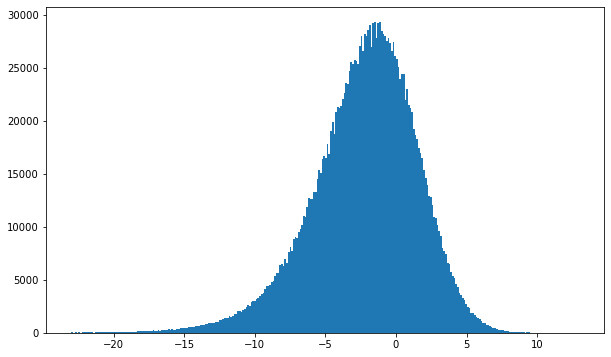

In [11]:
plt.rcParams['figure.figsize'] = (10, 6)

plt.hist(df1[df1["adjusted_strokes_gained"] > -23]["adjusted_strokes_gained"], bins=300)

plt.show();

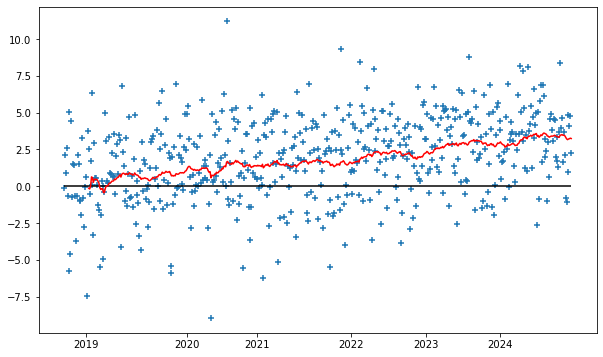

In [27]:
# Configurable minimum number of points per year
min_points = 20  # Example: only include years with at least 10 data points

# Scatter plot for original data
plt.scatter(dff.index, dff["adjusted_strokes_gained"], marker="+")

# Line plot for EWMA
plt.plot(dff.index, dff["ewma"], color="red")

# Horizontal line at y=0
plt.hlines(0, xmin=dff.index[0], xmax=dff.index[-1], color="black")

# Set title
plt.title(f"Round History (Adjusted Strokes Gained, with EWMA): {dff.name.values[0]}")

# Convert date column to datetime if necessary
dff["date"] = pd.to_datetime(dff["date"])

# Extract unique years
unique_years = dff["date"].dt.year.unique()

# Find the index corresponding to the first occurrence of each year,
# but only include years with at least `min_points` data points
year_indices = [
    dff[dff["date"].dt.year == year].index[0]
    for year in unique_years
    if len(dff[dff["date"].dt.year == year]) >= min_points
]

# Filter unique years for labeling, ensuring they match the filtered indices
filtered_years = [
    year
    for year in unique_years
    if len(dff[dff["date"].dt.year == year]) >= min_points
]

# Set ticks at these indices
plt.gca().set_xticks(year_indices)

# Set tick labels as the filtered years
plt.gca().set_xticklabels(filtered_years)

plt.title("")

plt.show();

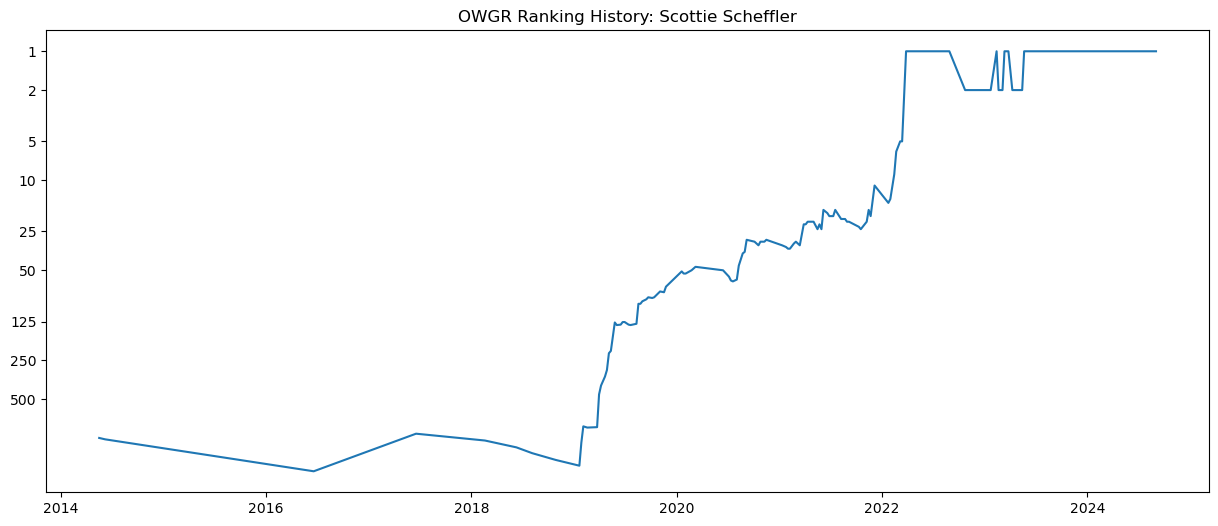

In [57]:
plt.plot(df1["date"], df1["end_rank"])

# Set major ticks to show one tick for each year
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())   # Set a tick for each year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks to show only the year

# Set the y-axis to logarithmic scale (base 2)
plt.yscale('log', base=2)

# Find the maximum value in the 'end_rank' column
max_rank = df1["end_rank"].max()

# Define the custom ticks you want to display
custom_ticks = [1, 2, 5, 10, 25, 50, 125, 250, 500]

# Filter ticks based on the maximum rank value
y_ticks = [tick for tick in custom_ticks if tick <= max_rank]

plt.yticks(y_ticks)

# Optionally, set y-tick labels as the original values
plt.gca().set_yticklabels(y_ticks)

# Invert the y-axis
plt.gca().invert_yaxis()

plt.title(f"OWGR Ranking History: {df1.name.values[0]}")

# Display the plot
plt.show();

## Attempt at Making Class types for data for regularity

In [132]:
# first generate player class
class Player():
    def __init__(self, name, player_id):
        self.name = name
        self.player_id = player_id
        self.tournaments = []
        self.ranking = np.nan
        
players = [Player(name, player_id) for name, player_id in zip(df.drop_duplicates("player_id")["name"], df.drop_duplicates("player_id")["player_id"])]

class Tournament():
    def __init__(self, df):
        self.df = df.copy()
        self.tournament_id = df.tournament_id.values[0]
        self.tour_id = df.tour_id.values[0]
        self.tour_name = df.tour_name.values[0]
        self.tour_code = df.tour_code.values[0]
        self.date = df.date.values[0]
        self.week = df.week.values[0]
        self.year = df.year.values[0]
        self.is_eligible = df.is_eligible.values[0]
        self.field_rating = df.field_rating.values[0]

        # check the round columns if they have a non na value then the round exists
        self.num_rounds = sum([(df[f"R{i}"].notna().sum() != 0) for i in list(range(1, 6))])

        # get the list of players, get the Player objects
        self.players = [player for player in players if player.player_id in df.player_id.values]

        # add the tournament objects to the Player objects if the tournament hasn't already been added
        for player in self.players:
            if self.tournament_id not in [tournament.tournament_id for tournament in player.tournaments]:
                player.tournaments.append(self)

        self.rounds = [Round(self, round_num) for round_num in list(range(1, self.num_rounds + 1))]

        self.results = dict(zip(df["player_id"], df["position"]))
        
class Round():
    def __init__(self, tournament, round_num):
        self.tournament_id = tournament.tournament_id
        self.tour_id = tournament.tour_id
        self.tour_name = tournament.tour_name
        self.tour_code = tournament.tour_code
        self.round_num = round_num

        # assume the tournament date is the date of final round, and subtract number of days before round
        self.date = tournament.date - pd.Timedelta(tournament.num_rounds - round_num, "d")
        
        self.scores = dict(zip(tournament.df["player_id"], tournament.df[f"R{round_num}"]))

In [134]:
tournament = Tournament(df2)
tournament

In [135]:
tournament.players[0].tournaments

In [64]:
class Player():
    def __init__(self, df):
        self.df = df.copy()
        self.name = df.name.values[0]
        self.player_id = df.player_id.values[0]
        self.ranking = np.nan

In [69]:
player = Player(df1)
player

# Bottom